# EDA CHUYÊN SÂU TRÊN CÁC ĐẠI DIỆN 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from sklearn.ensemble import IsolationForest
import matplotlib.dates as mdates

## Chuẩn bị dữ liệu cho các Quốc gia Đại diện
Trước tiên, ta lọc dữ liệu chỉ lấy các quốc gia đại diện mà bạn đã chọn từ kết quả phân cụm (USA, India, Israel, Yemen, Sweden).

In [2]:
df_1 = pd.read_csv('../data/processed/01_clean_daily_timeseries.csv.gz')

In [12]:
rep_countries = {
    'United States of America': 0, 
    'India': 1, 
    'Israel': 2, 
    'Yemen': 3, 
    'Sweden': 4
}

# LỌC DỮ LIỆU TỪ df_1 (TIME SERIES)
df_1['Date_reported'] = pd.to_datetime(df_1['Date_reported'])

# Lấy dữ liệu của các nước đại diện
df_rep = df_1[df_1['Country'].isin(rep_countries)].copy()

print(f"Đã lọc dữ liệu cho {len(rep_countries)} quốc gia đại diện.")
print(df_rep['Country'].unique())

Đã lọc dữ liệu cho 5 quốc gia đại diện.
['India' 'Israel' 'Sweden' 'United States of America' 'Yemen']


## 4.3.1. Phân tích Chuỗi thời gian chi tiết


### 4.3.1.1. Hình thái và các đợt bùng phát
Phần này vẽ biểu đồ so sánh và dùng thuật toán find_peaks của scipy để đếm số lượng làn sóng dịch (Waves) một cách tự động thay vì đếm bằng mắt.

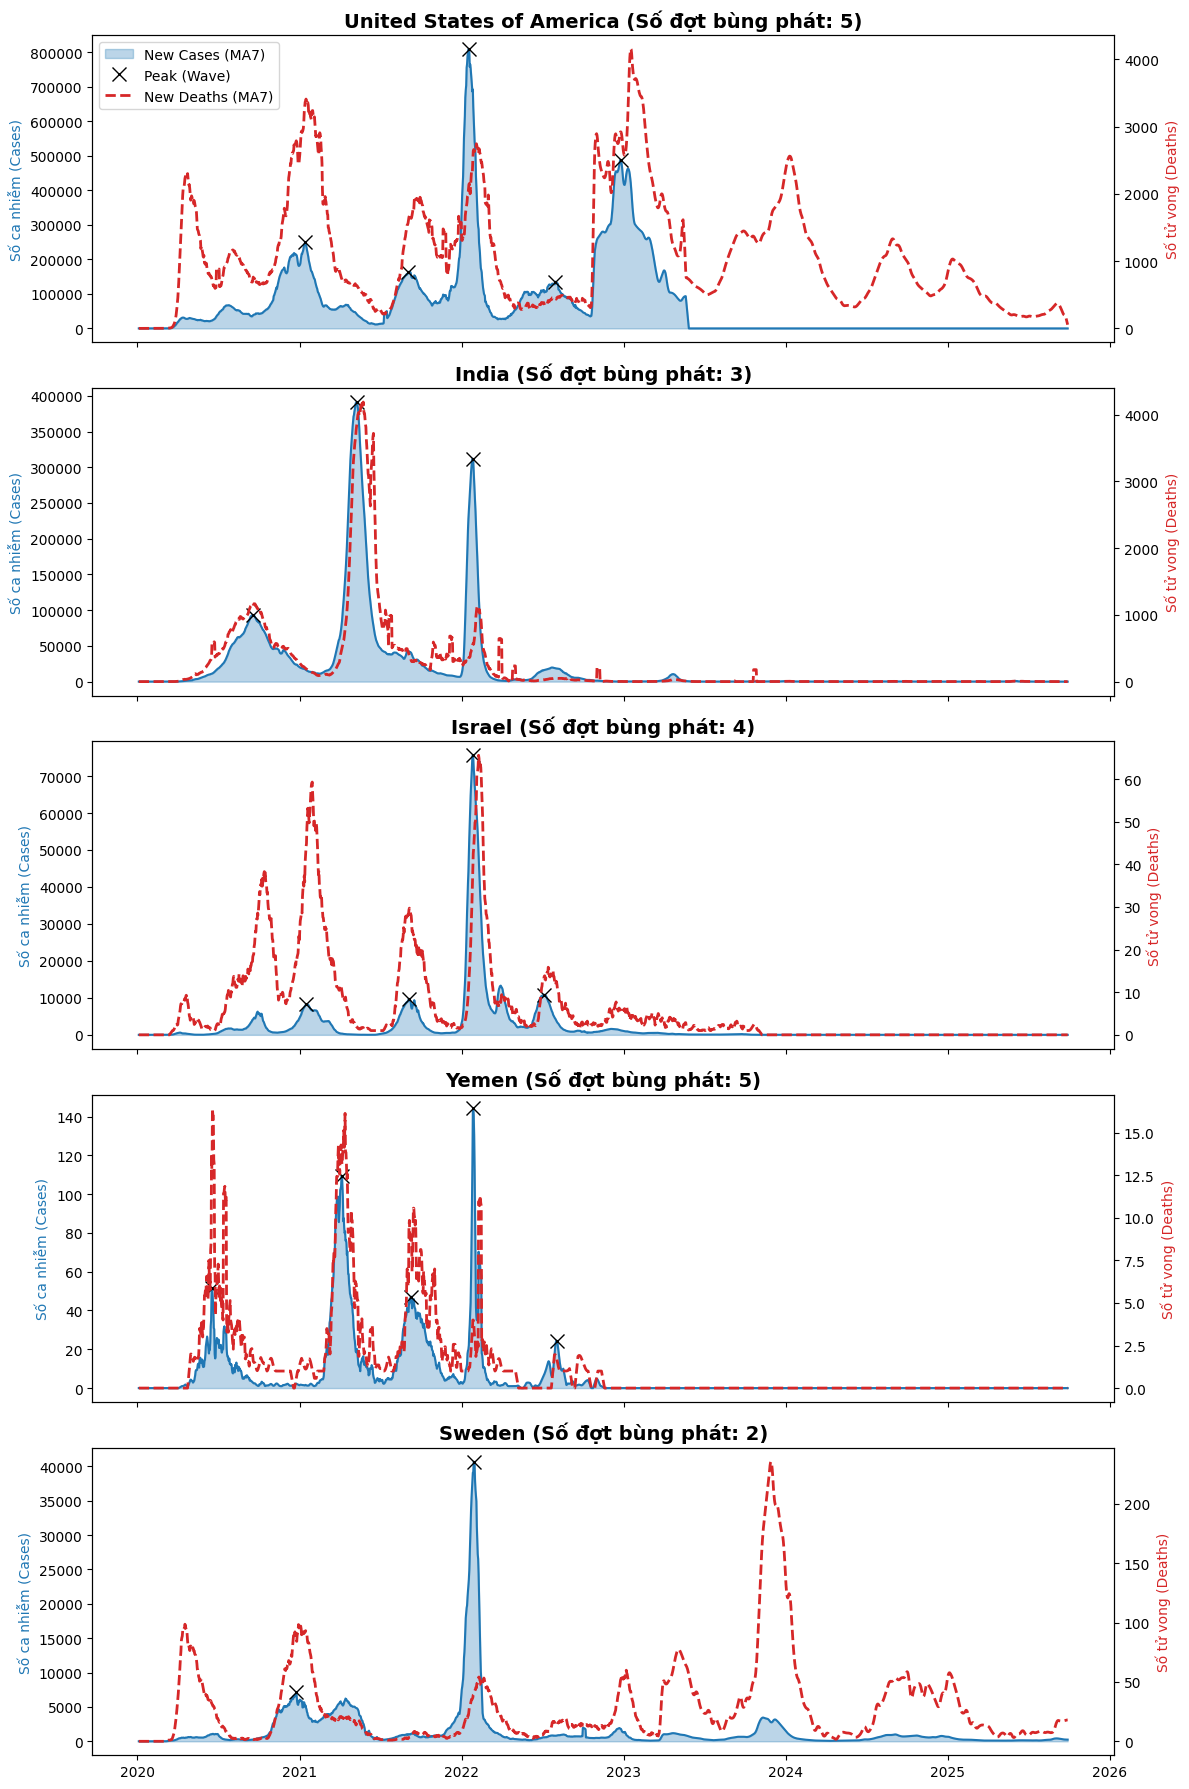

Số lượng đợt bùng phát (Waves) phát hiện được: {'United States of America': 5, 'India': 3, 'Israel': 4, 'Yemen': 5, 'Sweden': 2}


In [29]:
fig, axes = plt.subplots(len(rep_countries), 1, figsize=(12, 18), sharex=True)

# Tạo dictionary để lưu số lượng wave tìm được
wave_counts = {}

for i, country in enumerate(rep_countries):
    data = df_rep[df_rep['Country'] == country].sort_values('Date_reported')
    y_cases = data['New_cases_MA7'].fillna(0).values
    y_deaths = data['New_deaths_MA7'].fillna(0).values
    x_dates = data['Date_reported'].values
    
    # 1. Vẽ biểu đồ
    ax1 = axes[i]
    ax2 = ax1.twinx() # Trục y thứ 2 cho tử vong
    
    # Vẽ Ca nhiễm
    ax1.fill_between(x_dates, y_cases, color='tab:blue', alpha=0.3, label='New Cases (MA7)')
    ax1.plot(x_dates, y_cases, color='tab:blue', linewidth=1.5)
    
    # Vẽ Tử vong
    ax2.plot(x_dates, y_deaths, color='tab:red', linewidth=2, linestyle='--', label='New Deaths (MA7)')
    
    # 2. Thuật toán tìm đỉnh (Peak Detection)
    # distance=60: Các đỉnh phải cách nhau ít nhất 60 ngày (tránh đỉnh nhiễu)
    # prominence: Độ nổi bật của đỉnh so với xung quanh
    peaks, _ = find_peaks(y_cases, distance=60, prominence=np.max(y_cases)*0.1)
    
    # Đánh dấu đỉnh lên biểu đồ
    ax1.plot(x_dates[peaks], y_cases[peaks], "x", color='black', markersize=10, label='Peak (Wave)')
    
    # Lưu số lượng wave
    wave_counts[country] = len(peaks)
    
    # Trang trí
    ax1.set_title(f'{country} (Số đợt bùng phát: {len(peaks)})', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Số ca nhiễm (Cases)', color='tab:blue')
    ax2.set_ylabel('Số tử vong (Deaths)', color='tab:red')
    
    if i == 0: # Chỉ hiện legend ở hình đầu tiên cho đỡ rối
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xlabel('Thời gian')
plt.tight_layout()
plt.savefig("../results/charts/num_waves.png")
plt.show()

print("Số lượng đợt bùng phát (Waves) phát hiện được:", wave_counts)

Quan sát biểu đồ chuỗi thời gian ca nhiễm (vùng màu xanh) và tử vong (đường nét đứt màu đỏ) của 5 quốc gia đại diện, ta nhận thấy sự phân hóa rõ rệt về **hình thái sóng (Wave Morphology)** và **mối tương quan nhiễm - tử vong**:

**1. Hoa Kỳ (Cluster 0 - Tâm dịch dai dẳng)**

* Số lượng sóng: Thuật toán phát hiện 5 đợt bùng phát lớn.

* Hình thái: Các đợt sóng nối tiếp nhau liên tục với biên độ rất lớn (đỉnh dịch lên tới 800.000 ca/ngày). Điều này phản ánh đặc điểm của một quốc gia có quy mô dân số lớn và sự lây lan dịch bệnh diễn ra trên diện rộng, kéo dài qua nhiều năm mà không có giai đoạn "nghỉ" rõ rệt.

* Tương quan: Đường tử vong bám sát đường ca nhiễm trong các làn sóng đầu, nhưng biên độ thấp hơn hẳn ở các làn sóng sau (năm 2022 trở đi), cho thấy hiệu quả của miễn dịch cộng đồng và vắc-xin.

**2. Ấn Độ (Cluster 1 - Bùng nổ cường độ cao)**

* Số lượng sóng: Phát hiện 3 đợt bùng phát.

* Hình thái: Khác với Mỹ, đồ thị của Ấn Độ có dạng "Khoảng lặng - Bùng nổ". Điển hình là đợt sóng thứ 2 (khoảng giữa năm 2021 - biến chủng Delta) tạo thành một đỉnh nhọn cực đại, cao gấp nhiều lần so với đợt 1, sau đó giảm rất nhanh.

* Nhận định: Đây là hình thái đặc trưng của các quốc gia đang phát triển có mật độ dân số dày đặc: Khi dịch bùng phát sẽ tạo ra áp lực cực lớn trong thời gian ngắn (Shock), sau đó đạt đỉnh và suy giảm nhanh.

**3. Israel (Cluster 2 - Chu kỳ lặp lại & Hiệu quả Vắc-xin)**

* Số lượng sóng: Phát hiện 4 đợt bùng phát.

* Hình thái: Các đợt sóng xuất hiện đều đặn với tần suất dày đặc.

* Điểm đặc biệt (Quan trọng): Hãy quan sát sự "tách rời" (decoupling) giữa Ca nhiễm và Tử vong.

   * Ở các làn sóng đầu (2020), đường màu đỏ (tử vong) tăng rất cao cùng với ca nhiễm.
   
   * Ở làn sóng lớn nhất (2022 - biến chủng Omicron), dù cột màu xanh dựng đứng (số ca nhiễm kỷ lục), nhưng đường màu đỏ lại nằm rất thấp.
   
   * $\rightarrow$ Đây là bằng chứng trực quan nhất cho Cụm 2 (Cluster 2): Các quốc gia kiểm soát tốt tử vong nhờ chiến dịch tiêm chủng thần tốc.
   
**4. Yemen (Cluster 3 - Dữ liệu bất thường/Ngoại lệ)**

* Số lượng sóng: Máy đếm được 5 đỉnh, nhưng hãy nhìn vào trục tung (Y-axis).

* Hình thái: Số ca nhiễm cực thấp (chỉ khoảng 140 ca/ngày ở đỉnh), đường biểu diễn bị đứt đoạn và nhiễu.

* Tương quan (Rất quan trọng): Đường màu đỏ (Tử vong) gần như trùng khít hoặc cao ngang ngửa với vùng màu xanh (Ca nhiễm).

   * Điều này giải thích tại sao Yemen có CFR lên tới 18% trong bảng đặc trưng. Do thiếu năng lực xét nghiệm, họ chỉ ghi nhận những ca bệnh rất nặng (sắp tử vong), bỏ qua hầu hết các ca nhiễm nhẹ trong cộng đồng. Đây là mô hình "Tảng băng chìm".
   
**5. Thụy Điển (Cluster 4 - Mô hình khác biệt)**

* Số lượng sóng: Chỉ phát hiện 2 đợt bùng phát lớn rõ rệt theo thuật toán.

* Hình thái: Khác với các nước Châu Âu khác thường có nhiều đỉnh nhỏ, Thụy Điển có một đỉnh cực lớn vào năm 2022. Giai đoạn đầu (2020-2021), số ca nhiễm (vùng xanh) trông có vẻ thấp nhưng đường tử vong (nét đứt đỏ) lại khá cao.

* Nhận định: Điều này phản ánh chính sách "Không phong tỏa" (No Lockdown) gây tranh cãi ban đầu, dẫn đến tỷ lệ tử vong cao trong giai đoạn đầu dịch dù số ca nhiễm ghi nhận không quá đột biến (do ít xét nghiệm đại trà thời điểm đó).

### 4.3.1.2. Phân tích cấu trúc và tính dừng

#### a. Phân rã chuỗi thời gian (DECOMPOSITION)

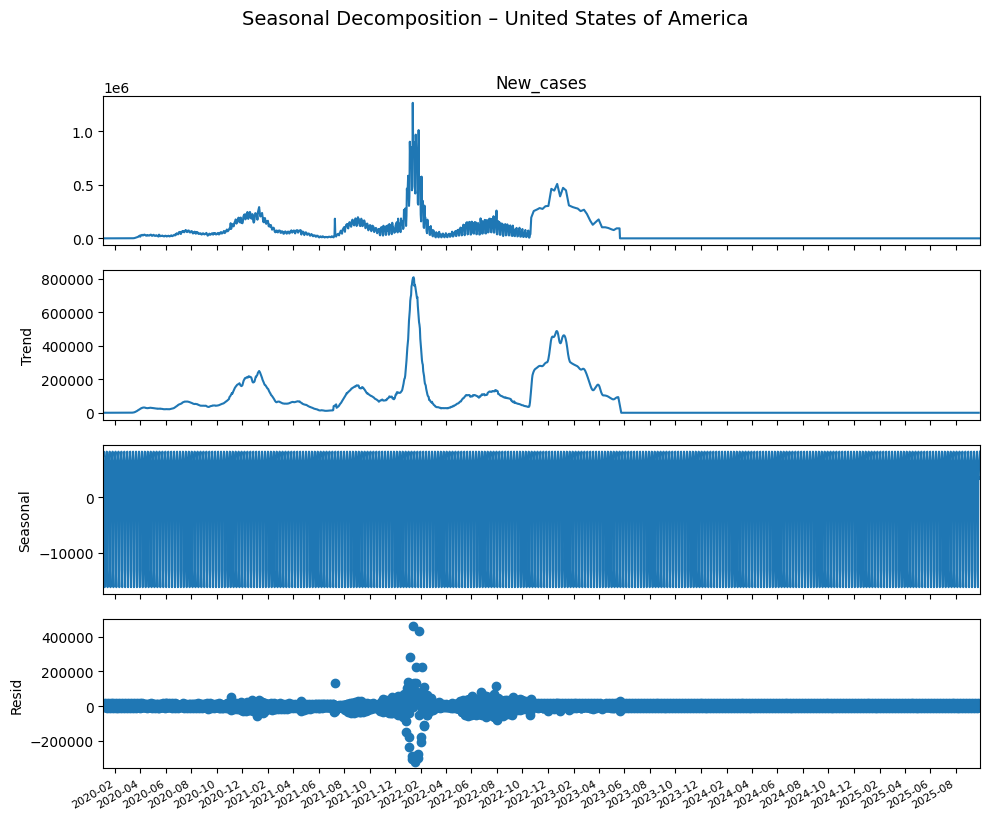

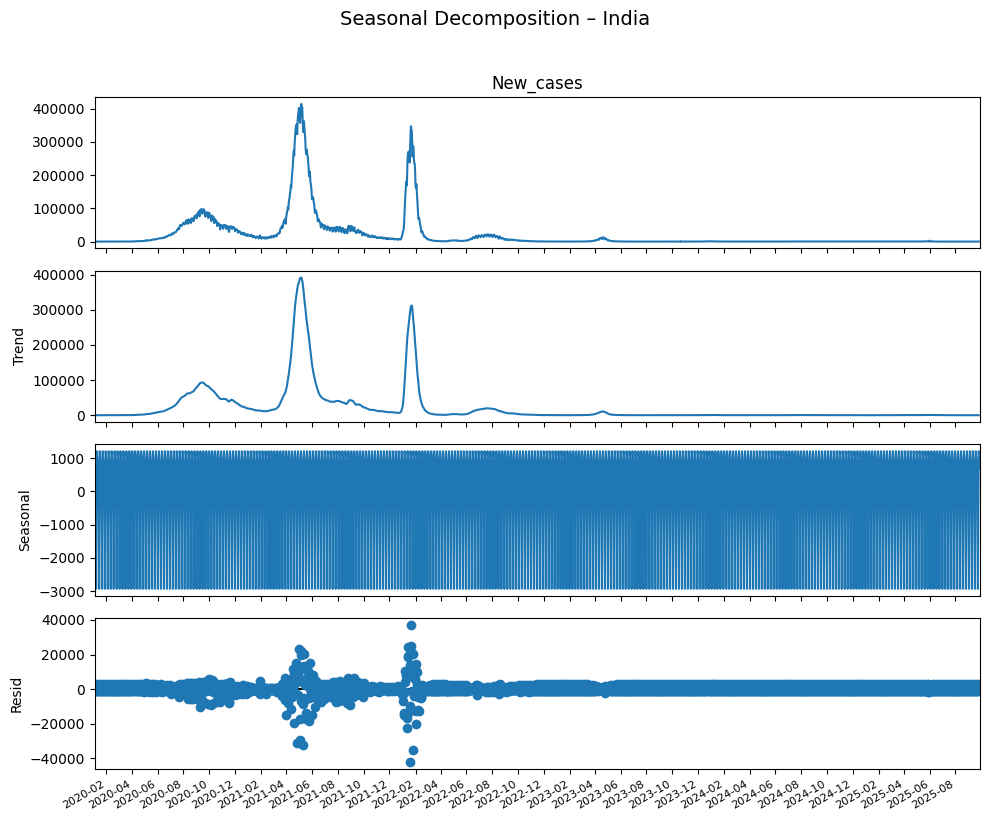

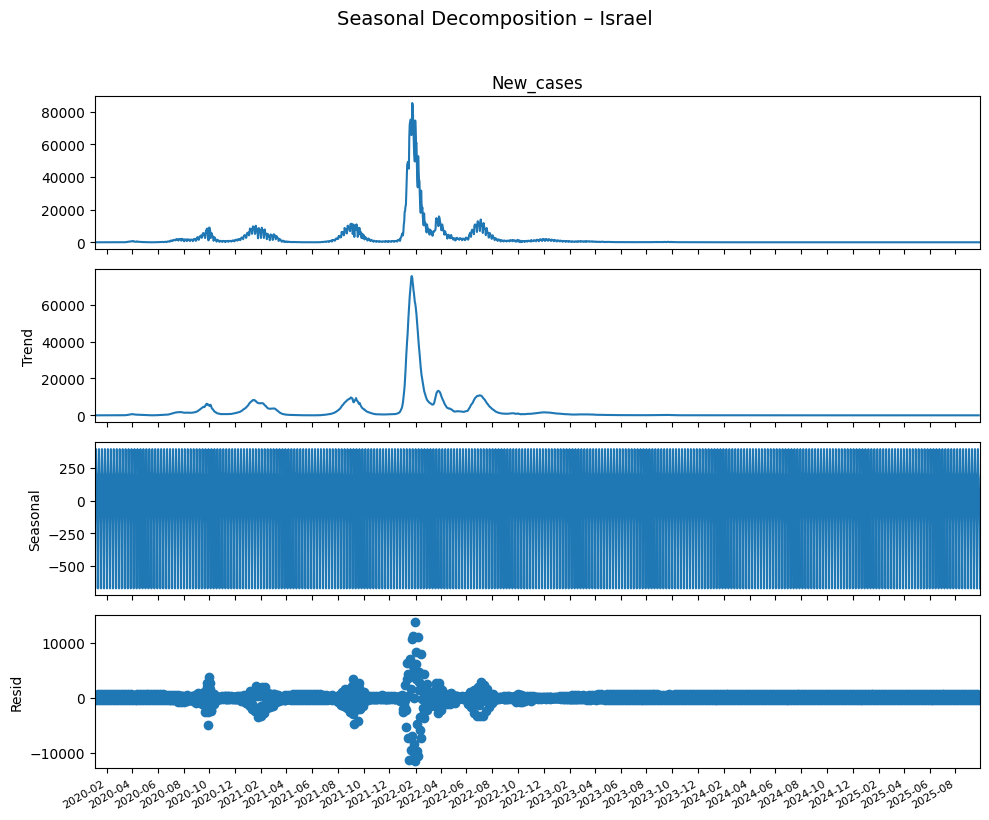

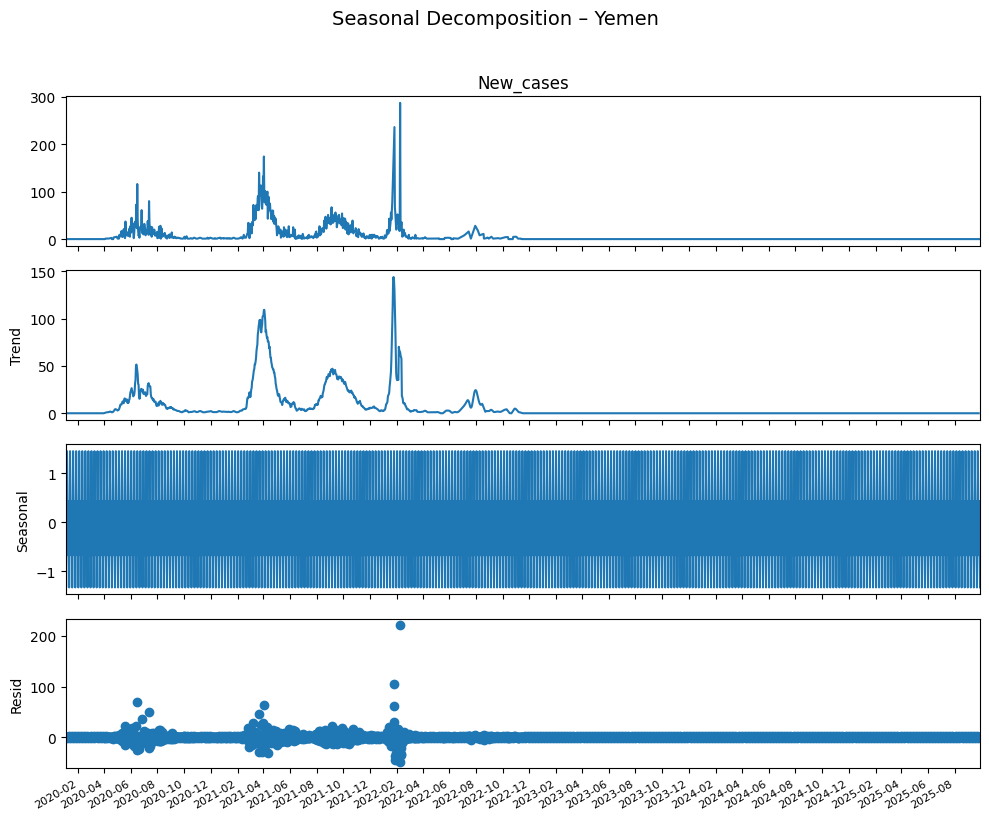

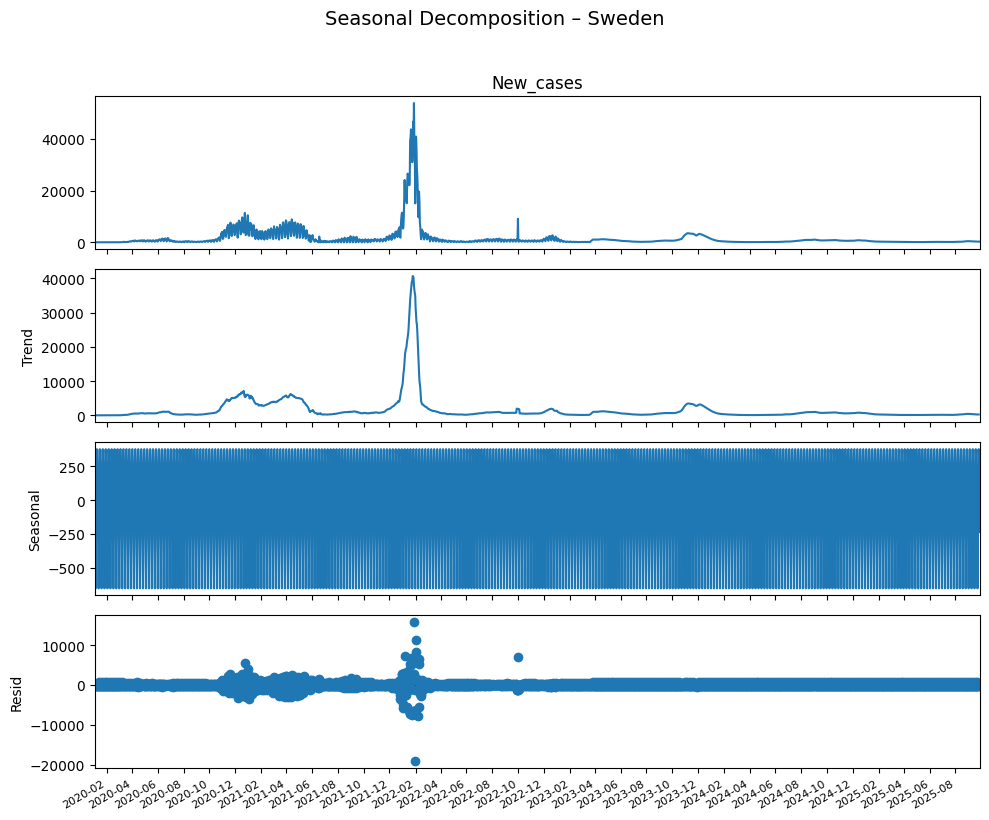

In [21]:
import matplotlib.dates as mdates
for c in rep_countries:
    # Lọc dữ liệu
    sub = df_rep[df_rep["Country"] == c].set_index("Date_reported")

    series = sub["New_cases"].fillna(0) 

    result = seasonal_decompose(series, model="additive", period=7)

    fig = result.plot()
    
    fig.set_size_inches(10, 8)

    plt.suptitle(f"Seasonal Decomposition – {c}", fontsize=14, y=1.02)

    for ax in fig.axes:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', labelsize=8)

    fig.autofmt_xdate()

    plt.tight_layout()
  
    safe_name = c.replace(' ', '_').lower()
    plt.savefig(f"../results/charts/seasonal_decomposition_covid19_{safe_name}.png", bbox_inches='tight')
    
    plt.show()
    plt.close(fig)

#### b. Kiểm định tính dừng (ADF TEST)

In [28]:
from statsmodels.tsa.stattools import adfuller

for c in rep_countries:
    print(f"\n=== KẾT QUẢ KIỂM ĐỊNH ADF ({c}) ===")
    sub = df_rep[df_rep["Country"] == c].set_index("Date_reported")

    series = sub["Cumulative_cases"].fillna(0) 
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] > 0.05:
        print("=> KẾT LUẬN: Chuỗi KHÔNG DỪNG (Non-stationary). Cần lấy sai phân trước khi dự báo.")
    else:
        print("=> KẾT LUẬN: Chuỗi DỪNG (Stationary).")


=== KẾT QUẢ KIỂM ĐỊNH ADF (United States of America) ===
ADF Statistic: -2.0807
p-value: 0.2523
Critical Values:
	1%: -3.4335
	5%: -2.8629
	10%: -2.5675
=> KẾT LUẬN: Chuỗi KHÔNG DỪNG (Non-stationary). Cần lấy sai phân trước khi dự báo.

=== KẾT QUẢ KIỂM ĐỊNH ADF (India) ===
ADF Statistic: -2.3261
p-value: 0.1637
Critical Values:
	1%: -3.4335
	5%: -2.8629
	10%: -2.5675
=> KẾT LUẬN: Chuỗi KHÔNG DỪNG (Non-stationary). Cần lấy sai phân trước khi dự báo.

=== KẾT QUẢ KIỂM ĐỊNH ADF (Israel) ===
ADF Statistic: -1.5002
p-value: 0.5334
Critical Values:
	1%: -3.4335
	5%: -2.8629
	10%: -2.5675
=> KẾT LUẬN: Chuỗi KHÔNG DỪNG (Non-stationary). Cần lấy sai phân trước khi dự báo.

=== KẾT QUẢ KIỂM ĐỊNH ADF (Yemen) ===
ADF Statistic: -2.7755
p-value: 0.0619
Critical Values:
	1%: -3.4335
	5%: -2.8629
	10%: -2.5675
=> KẾT LUẬN: Chuỗi KHÔNG DỪNG (Non-stationary). Cần lấy sai phân trước khi dự báo.

=== KẾT QUẢ KIỂM ĐỊNH ADF (Sweden) ===
ADF Statistic: -1.8334
p-value: 0.3640
Critical Values:
	1%: -3.4335

#### c. Biểu đồ tự tương quan (ACF & PACF)

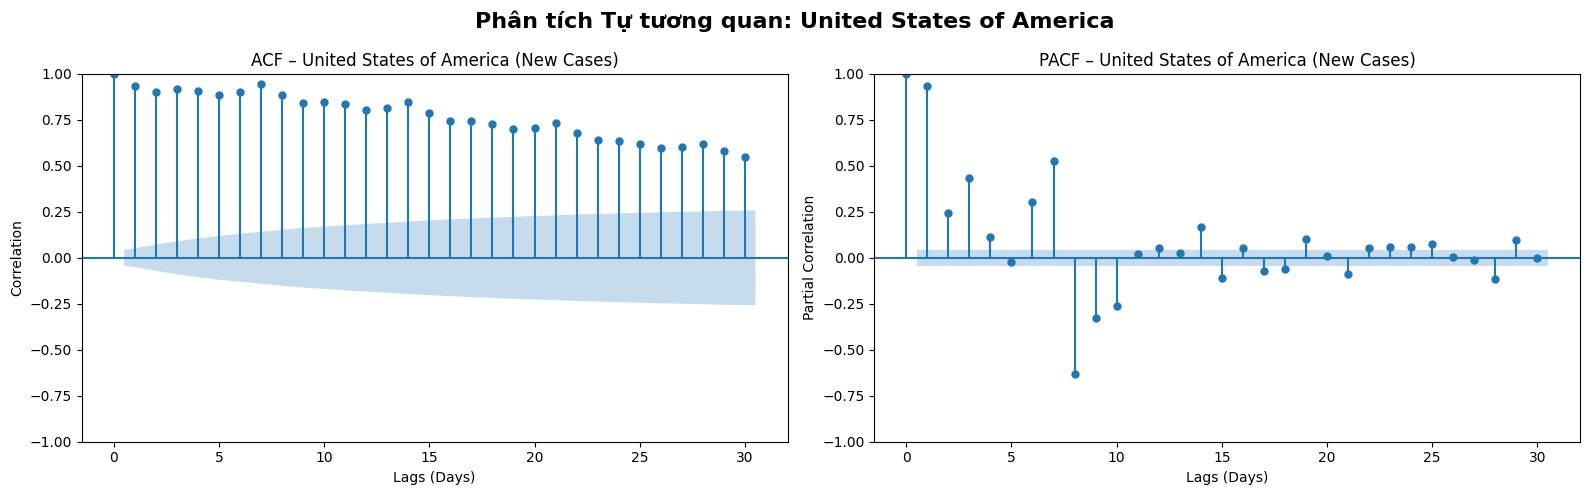

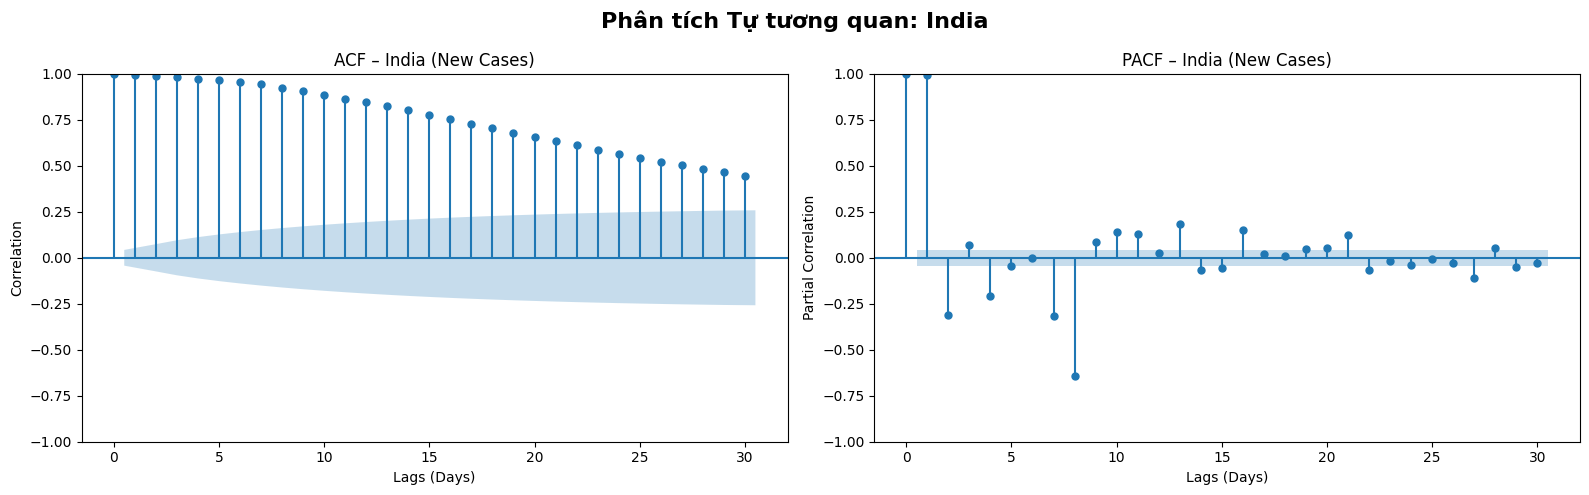

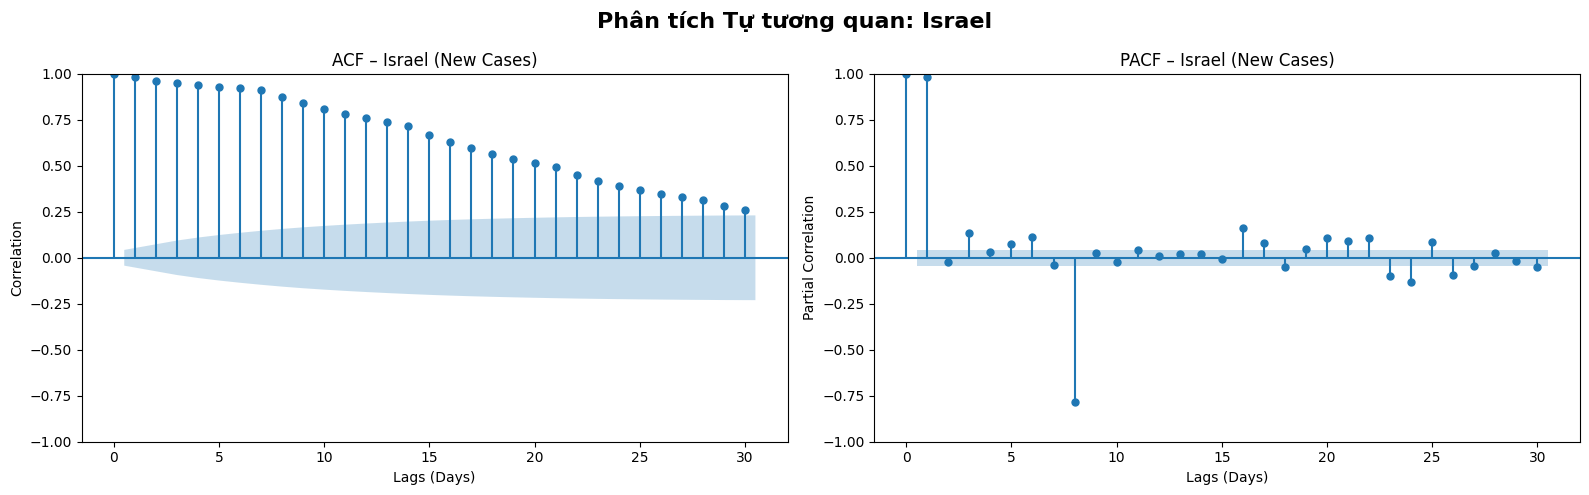

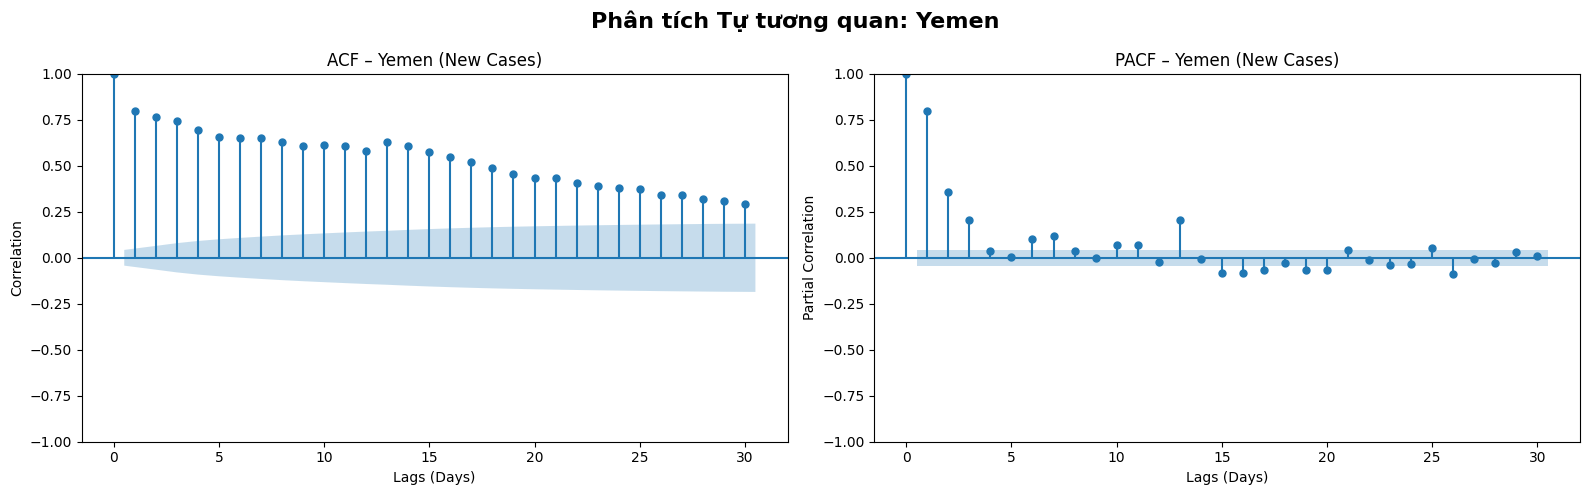

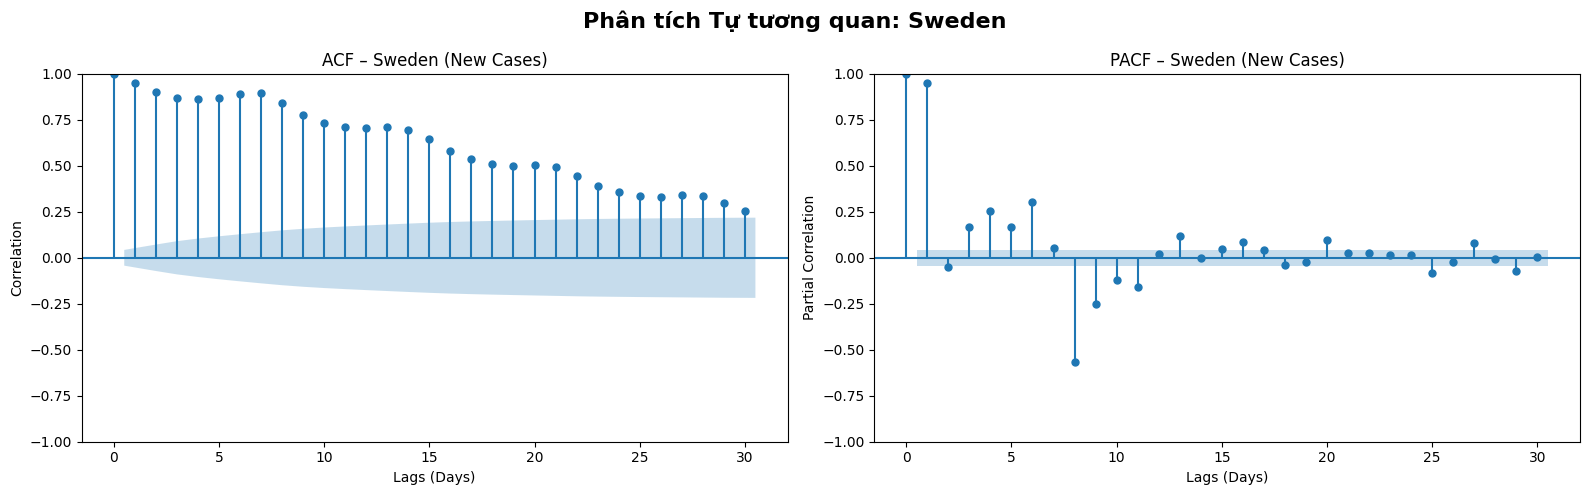

In [23]:
for c in rep_countries:
    
    sub = df_rep[df_rep["Country"] == c]["New_cases"].fillna(0)
    
    # Kiểm tra nếu dữ liệu quá ít thì bỏ qua để tránh lỗi
    if len(sub) < 30:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Vẽ ACF bên trái
    plot_acf(sub, lags=30, ax=axes[0], title=f"ACF – {c} (New Cases)")
    axes[0].set_xlabel('Lags (Days)')
    axes[0].set_ylabel('Correlation')

    # Vẽ PACF bên phải
    plot_pacf(sub, lags=30, method="ywm", ax=axes[1], title=f"PACF – {c} (New Cases)")
    axes[1].set_xlabel('Lags (Days)')
    axes[1].set_ylabel('Partial Correlation')

    plt.suptitle(f"Phân tích Tự tương quan: {c}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Lưu file
    filename = f"../results/charts/acf_pacf_{c.replace(' ', '_').lower()}.png"
    plt.savefig(filename)
    plt.show()
    plt.close()

Quan sát tổng quan cả 5 quốc gia, ta nhận thấy một mô hình chung (Pattern) rất đặc trưng của dữ liệu chuỗi thời gian dịch tễ:

1. **Tính Tự hồi quy mạnh (Strong Autoregression):**

* **Biểu đồ ACF**: Tại tất cả các quốc gia, hệ số tự tương quan khởi đầu rất cao (gần 1.0) và giảm dần rất chậm (tailing off) theo dạng hình học hoặc tuyến tính. Điều này cho thấy dữ liệu có "trí nhớ dài hạn" (long memory) – số ca nhiễm hôm nay bị ảnh hưởng mạnh bởi chuỗi ca nhiễm của nhiều ngày trước đó.

* **Biểu đồ PACF**: Có một gai (spike) rất lớn tại `Lag 1` (gần bằng 1) và sau đó giảm mạnh hoặc dao động quanh 0. Đây là dấu hiệu sách giáo khoa của một quá trình Tự hồi quy (AR - AutoRegressive).

2. **Dấu hiệu Mùa vụ (Seasonality):**

* Tại biểu đồ PACF của một số quốc gia (đặc biệt là Sweden và Israel), xuất hiện các gai bất thường tại Lag 7, Lag 8 hoặc Lag 14. Đây là minh chứng rõ ràng cho tính chu kỳ tuần (Weekly Seasonality) do quy trình báo cáo số liệu (thường giảm vào cuối tuần và tăng vọt vào đầu tuần).

**CHI TIẾT TỪNG QUỐC GIA**

1. **United States of America (USA)**

* ACF: Giảm dần đều đặn, tất cả các lag từ 1-30 đều vượt ngưỡng ý nghĩa (vùng xanh nhạt). Điều này xác nhận xu hướng (Trend) mạnh trong dữ liệu.

* PACF: Gai lớn nhất tại Lag 1 (~0.9), gai thứ hai tại Lag 2 (~0.4) và Lag 3.

2. **Israel**

* ACF: Giảm chậm tương tự Mỹ.

* PACF: Sau Lag 1 rất cao, ta thấy các gai âm đáng chú ý quanh Lag 7 và Lag 8.

* Kết luận: Dữ liệu của Israel chịu ảnh hưởng bởi tính mùa vụ tuần. Khi xây dựng mô hình, cần thêm đặc trưng lag_7 để bắt được quy luật này.

3. **Yemen**

* ACF: Mặc dù cũng giảm dần, nhưng độ dốc giảm nhanh hơn so với Mỹ hay Ấn Độ.

* PACF: Lag 1 dương (~0.8), nhưng Lag 2 cũng dương khá cao (~0.3). Các lag sau đó (3, 4, 5) dao động yếu.

* Kết luận: Dữ liệu Yemen có vẻ "nhiễu" hơn (ít mượt mà hơn), phản ánh đúng thực tế dữ liệu thiếu ổn định của cụm này (Cluster 3).

4. **India**
* ACF: Đường ACF giảm rất chậm, gần như một đường thẳng đi xuống. Đây là dấu hiệu cho thấy chuỗi dữ liệu có quán tính rất lớn.

* PACF: Gai Lag 1 xấp xỉ 1.0. Đặc biệt, Lag 2 có giá trị âm. Hiện tượng "Lag 1 dương cực lớn, Lag 2 âm" thường ám chỉ một sự "điều chỉnh quá mức" (over-correction) trong chuỗi dữ liệu, hoặc dữ liệu đã được làm trơn (Smoothing) quá kỹ.

5. **Sweden (Thụy Điển) - Trường hợp đặc biệt nhất**

* ACF: Tương tự các nước khác.

* PACF: Đây là biểu đồ thú vị nhất.

    * Lag 1 rất cao.

    * Lag 8 xuất hiện một gai ÂM cực lớn (gần -0.6).

    * Gai tại Lag 8 (tức là 7 + 1) là dấu hiệu cực mạnh của tính mùa vụ tuần bị lệch pha.

* Kết luận: Thụy Điển có quy trình báo cáo cuối tuần rất khác biệt (thường không báo cáo T7-CN và cộng dồn vào T3), tạo ra cú sốc thống kê định kỳ. Mô hình dự báo bắt buộc phải xử lý yếu tố Seasonality = 7 nếu không sai số sẽ rất lớn.

**KẾT LUẬN**

* Chọn biến Lag_1 là quan trọng nhất (do PACF Lag 1 luôn cao nhất)

* Xử lý Mùa vụ: Bắt buộc phải đưa biến lag_7 để xử lý tính chu kỳ tuần.

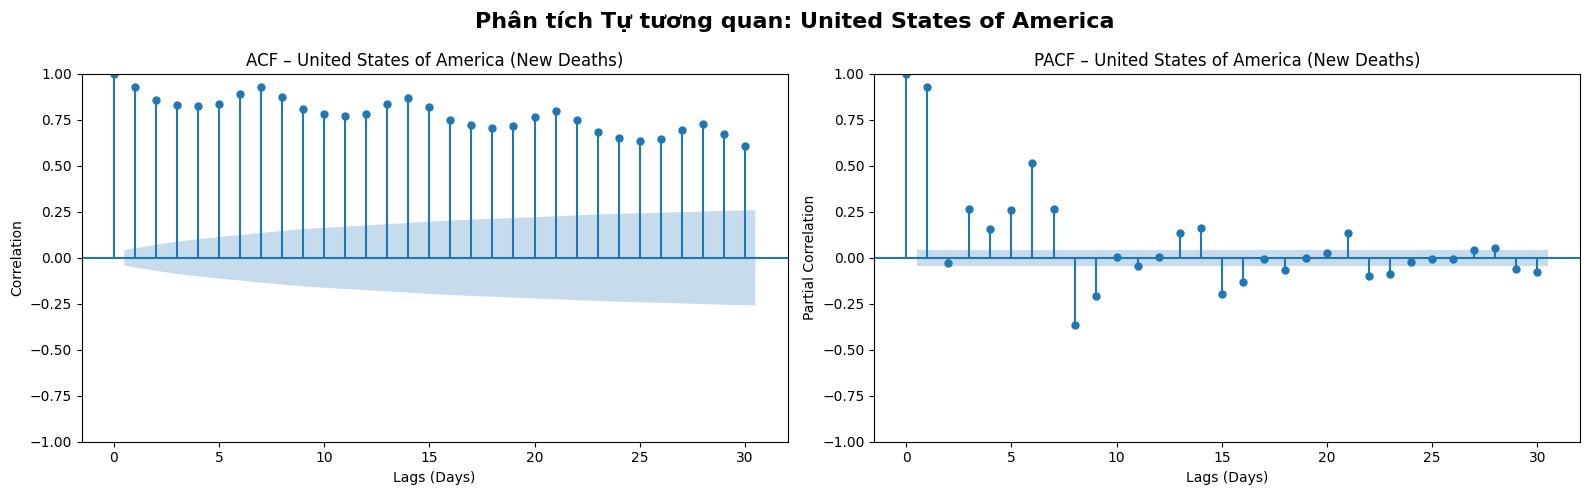

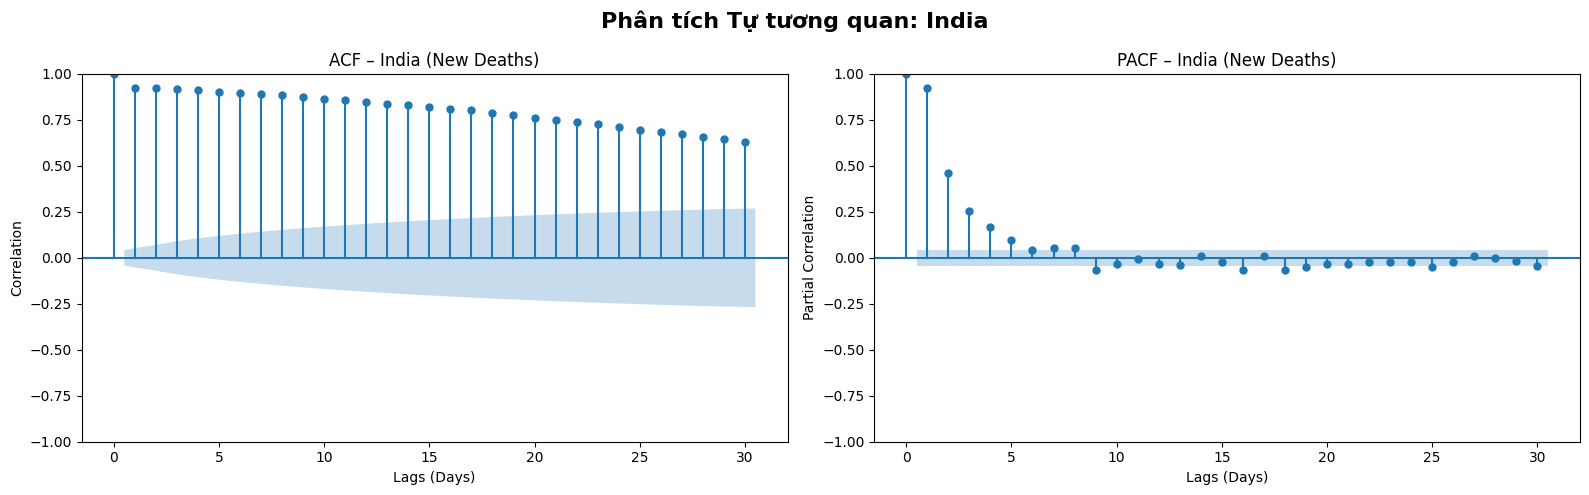

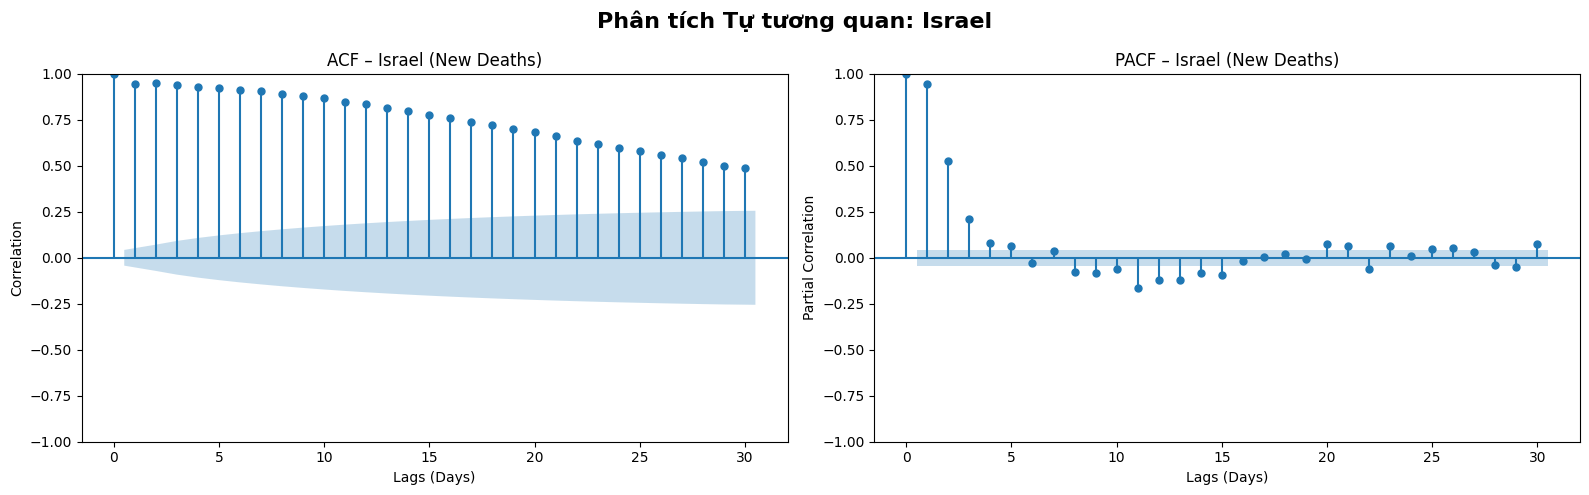

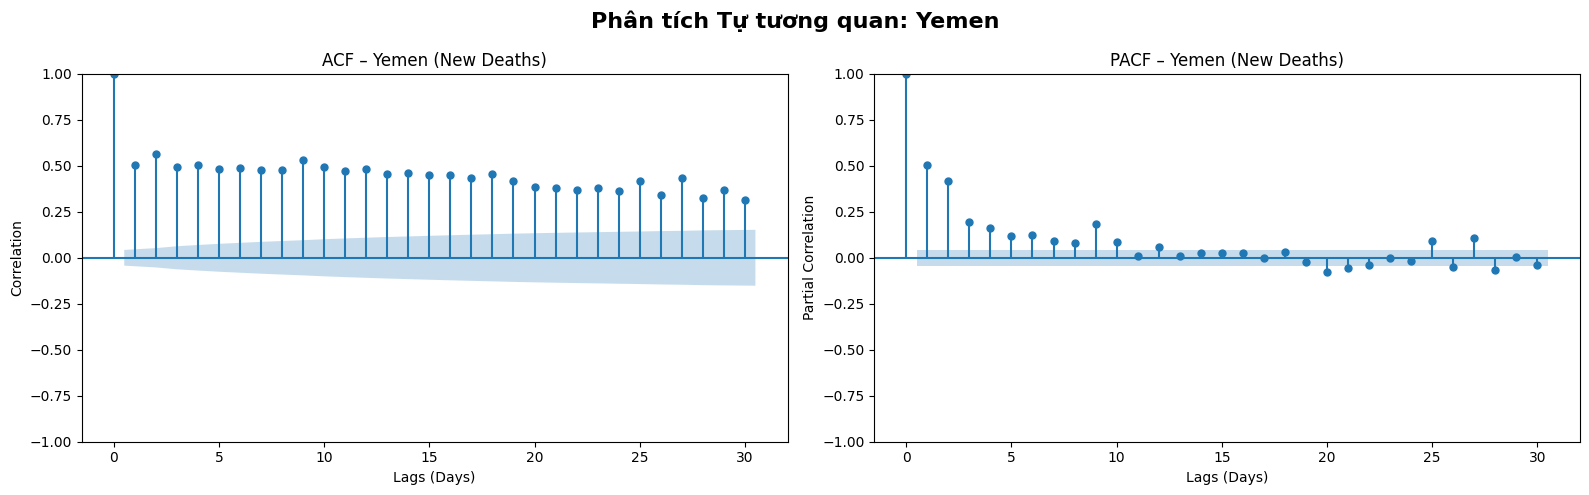

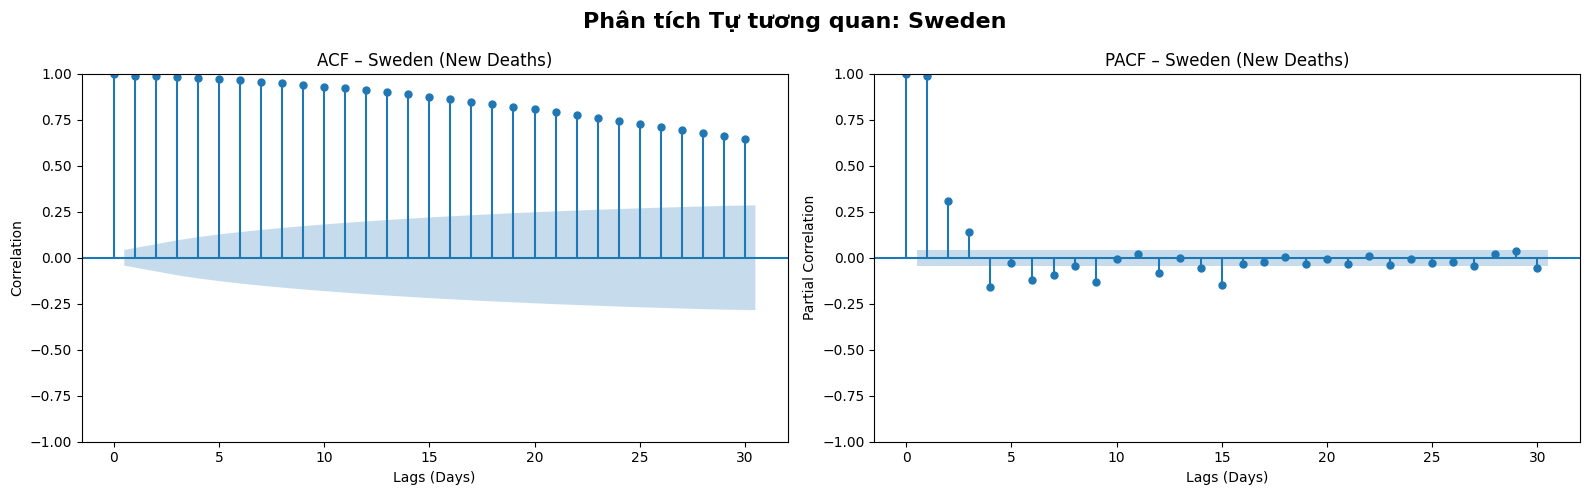

In [30]:
for c in rep_countries:
    
    sub = df_rep[df_rep["Country"] == c]["New_deaths"].fillna(0)
    
    # Kiểm tra nếu dữ liệu quá ít thì bỏ qua để tránh lỗi
    if len(sub) < 30:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Vẽ ACF bên trái
    plot_acf(sub, lags=30, ax=axes[0], title=f"ACF – {c} (New Deaths)")
    axes[0].set_xlabel('Lags (Days)')
    axes[0].set_ylabel('Correlation')

    # Vẽ PACF bên phải
    plot_pacf(sub, lags=30, method="ywm", ax=axes[1], title=f"PACF – {c} (New Deaths)")
    axes[1].set_xlabel('Lags (Days)')
    axes[1].set_ylabel('Partial Correlation')

    plt.suptitle(f"Phân tích Tự tương quan: {c}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Lưu file
    filename = f"../results/charts/acf_pacf_deaths_{c.replace(' ', '_').lower()}.png"
    plt.savefig(filename)
    plt.show()
    plt.close()

## 4.3.2 Phân tích Độ trễ Nhiễm - Tử vong (Cross-Correlation)

Phần này trả lời câu hỏi: "Sau khi số ca nhiễm tăng, bao lâu thì số ca tử vong tăng?" (Lag time).

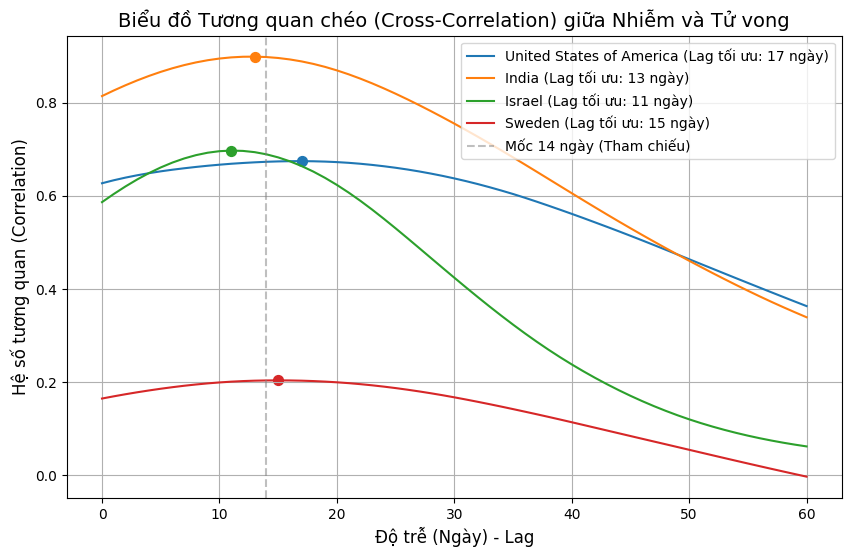

Độ trễ tối ưu (Optimal Lag) giữa đỉnh nhiễm và đỉnh tử vong: {'United States of America': 17, 'India': 13, 'Israel': 11, 'Sweden': 15}


In [27]:
def calculate_optimal_lag(df_country, country_name, max_lag=60):
    """
    Hàm tính tương quan chéo giữa Cases và Deaths khi dịch chuyển Deaths về sau 0-60 ngày
    """
    cases = df_country['New_cases_MA7'].fillna(0)
    deaths = df_country['New_deaths_MA7'].fillna(0)
    
    correlations = []
    lags = range(max_lag + 1)
    
    for lag in lags:
        # Shift deaths ngược lại (nghĩa là deaths xảy ra sau cases)
        # Tương quan giữa Cases(t) và Deaths(t + lag)
        shifted_deaths = deaths.shift(-lag) 
        corr = cases.corr(shifted_deaths)
        correlations.append(corr)
        
    # Tìm lag có tương quan cao nhất
    optimal_lag = np.argmax(correlations)
    max_corr = np.max(correlations)
    
    return lags, correlations, optimal_lag, max_corr

# Vẽ biểu đồ CCF Plot
plt.figure(figsize=(10, 6))

lag_results = {}

for country in rep_countries:
    df_c = df_rep[df_rep['Country'] == country]
    
    # Bỏ qua Yemen vì dữ liệu quá ít/nhiễu để tính lag
    if country == 'Yemen': continue 
        
    lags, corrs, opt_lag, max_corr = calculate_optimal_lag(df_c, country)
    
    lag_results[country] = opt_lag
    
    plt.plot(lags, corrs, label=f'{country} (Lag tối ưu: {opt_lag} ngày)')
    # Đánh dấu điểm cao nhất
    plt.scatter(opt_lag, max_corr, s=50)

plt.title('Biểu đồ Tương quan chéo (Cross-Correlation) giữa Nhiễm và Tử vong', fontsize=14)
plt.xlabel('Độ trễ (Ngày) - Lag', fontsize=12)
plt.ylabel('Hệ số tương quan (Correlation)', fontsize=12)
plt.axvline(x=14, color='gray', linestyle='--', alpha=0.5, label='Mốc 14 ngày (Tham chiếu)')
plt.legend()
plt.grid(True)
plt.savefig("../results/charts/ccf_plot_cases_deaths.png")
plt.show()

print("Độ trễ tối ưu (Optimal Lag) giữa đỉnh nhiễm và đỉnh tử vong:", lag_results)

## 4.3.3 Trích xuất Đặc trưng cuối cùng (Feature Table)
Tổng hợp lại tất cả các chỉ số (cả tĩnh và động) vào một bảng duy nhất để làm đầu vào cho kết luận hoặc mô hình nâng cao.

In [7]:
df_2 = pd.read_csv('../data/processed/02_country_population_summary.csv.gz')

In [15]:
df_rep_summary = df_2[df_2['Country'].isin(rep_countries)].copy()

In [ ]:
from scipy.stats import linregress
def get_wave_count(series_cases):
    peaks, _ = find_peaks(series_cases, distance=60, prominence=np.max(series_cases)*0.1)
    return len(peaks)

def get_optimal_lag(series_cases, series_deaths, max_lag=60):
    if series_deaths.sum() < 10 or series_cases.sum() < 100: return np.nan
    corrs = []
    for lag in range(max_lag + 1):
        shifted_deaths = series_deaths.shift(-lag)
        corr = series_cases.corr(shifted_deaths)
        corrs.append(corr)
    return np.argmax(corrs)

def get_slope_variance(series_cases):
    var = np.var(series_cases)
    y = series_cases.values
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return slope, var

print("Đã khai báo xong các hàm tính toán.")

Đã khai báo xong các hàm tính toán.


In [ ]:
final_features_data = []

for country in rep_countries:
    # 1. Lấy dữ liệu Time-series của nước đó
    ts_data = df_rep[df_rep['Country'] == country].sort_values('Date_reported')
    
    avg_growth = ts_data['Growth_Rate'].replace([np.inf, -np.inf], np.nan).mean()
    # Sử dụng cột MA7 (Moving Average) để tính toán cho mượt
    # Nếu trong file chưa có MA7, ta tự tính: ts_data['New_cases'].rolling(7).mean()
    cases_ma = ts_data['New_cases_MA7'].fillna(0)
    deaths_ma = ts_data['New_deaths_MA7'].fillna(0)
    
    # 2. Lấy dữ liệu Summary tĩnh của nước đó
    summary_data = df_rep_summary[df_rep_summary['Country'] == country].iloc[0]
    
    # 3. Tính toán các đặc trưng phức tạp (Gọi hàm ở Bước 2)
    n_waves = get_wave_count(cases_ma)
    lag_days = get_optimal_lag(cases_ma, deaths_ma)
    slope, variance = get_slope_variance(cases_ma)
    
    # 4. Gom hết vào dictionary
    final_features_data.append({
        'Cluster': rep_countries[country],    # Lấy từ map đã khai báo
        'Country': country,
        
        # Nhóm đặc trưng Mức độ (Lấy từ df_2)
        'Total_Cases_1M': summary_data['Cases_per_1M'],
        'CFR (%)': summary_data['Fatality_Rate'],
        
        # Nhóm đặc trưng Động học & Biến động (Mới tính)
        'Growth_Rate_Avg': avg_growth,
        'Slope (Overall)': slope,
        'Variance (Billions)': variance / 1_000_000, # Chia nhỏ số cho dễ nhìn
        'Num_Waves': n_waves,
        'Death_Lag (Days)': lag_days
    })

# Tạo DataFrame
df_433 = pd.DataFrame(final_features_data)
df_433 = df_433.round(2)

# Hiển thị bảng kết quả
print("=== BẢNG TRÍCH XUẤT ĐẶC TRƯNG CUỐI CÙNG (MỤC 4.3.3) ===")
display(df_433)

# Xuất ra Excel nếu cần
# df_433.to_excel('Final_Features_4.3.3.xlsx', index=False)

=== BẢNG TRÍCH XUẤT ĐẶC TRƯNG CUỐI CÙNG (MỤC 4.3.3) ===


,Cluster,Country,Total_Cases_1M,CFR (%),Growth_Rate_Avg,Slope (Overall),Variance (Billions),Num_Waves,Death_Lag (Days)
0,0,United States of America,308845.11,1.19,5.76,-49.63,14045.52,5,17
1,1,India,31330.97,1.18,6.37,-30.99,3123.89,3,13
2,2,Israel,496234.14,0.26,7.11,-2.15,57.22,4,11
3,3,Yemen,303.24,18.07,10.36,-0.01,0.00,5,1
4,4,Sweden,263773.76,1.04,391.06,-1.17,15.66,2,15


#### BIỂU ĐỒ: SEASONAL DECOMPOSITION (Trend – Seasonal – Residual)
Mục đích: Tách Trend, Seasonality và Residual

**Nhận xét:**
* Quan sát thành phần Xu hướng (Trend), ta thấy diễn biến dịch COVID-19 tại cả 4 quốc gia đều không tuân theo quy luật tuyến tính đơn giản mà trải qua các đợt bùng phát dạng sóng (waves). Các đỉnh sóng tương ứng với sự xuất hiện của các biến chủng mới (như Delta, Omicron)

* Thành phần mùa vụ (Seasonal) hiển thị rõ rệt rất rõ rệt với tần suất 7 ngày. Trục tung hiển thị các giá trị dao động quanh mức 0. Các đỉnh dương (positive peaks) đại diện cho những ngày đầu tuần khi số liệu thường được báo cáo bù, trong khi các đáy âm (negative troughs) phản ánh sự sụt giảm nhân tạo vào dịp cuối tuần

* Phần dư (Resid) dao động mạnh tại các thời điểm bùng dịch, cho thấy các yếu tố ngẫu nhiên
đóng vai trò lớn bên cạnh xu hướng chính (Trend).


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

target_countries = df["Country"].unique()
# 4. VẼ BIỂU ĐỒ VÒNG LẶP
for i, country in enumerate(target_countries):
    ax1 = axes[i] # Lấy trục vẽ hiện tại
    
    # Lọc dữ liệu theo nước
    country_df = df[df["Country"] == country].sort_values("Date_reported")
    
    # --- VẼ TRỤC TRÁI (LEFT Y-AXIS): SỐ CA NHIỄM ---
    color1 = 'tab:blue'
    ax1.set_xlabel('Thời gian')
    ax1.set_ylabel('Cases per 1M (Ca nhiễm)', color=color1, fontweight='bold')
    ax1.plot(country_df["Date_reported"], country_df["Cases_per_1M"], color=color1, label='Cases/1M')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3) 

    # --- VẼ TRỤC PHẢI (RIGHT Y-AXIS): SỐ CA TỬ VONG ---
    ax2 = ax1.twinx()  
    color2 = 'tab:red'
    ax2.set_ylabel('Deaths per 1M (Tử vong)', color=color2, fontweight='bold')
    ax2.plot(country_df["Date_reported"], country_df["Deaths_per_1M"], color=color2, linestyle='--', label='Deaths/1M')
    ax2.tick_params(axis='y', labelcolor=color2)

    ax1.set_title(f"Diễn biến dịch tại: {country}", fontsize=14, fontweight='bold')
    
    # Định dạng ngày tháng trục X
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6)) # 6 tháng hiện mốc 1 lần cho đỡ rối
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Lưu và hiển thị
plt.savefig("../results/charts/covid19_cases_vs_deaths_4_countries.png")
plt.show()
plt.close()


**Nhận diện "Độ trễ tử vong" (Lag Time):**

* Quan sát biểu đồ tại Mỹ và Ấn Độ, đỉnh dịch tử vong (đường nét đứt màu đỏ) thường xuất hiện sau đỉnh dịch lây nhiễm (đường màu xanh) khoảng 2-3 tuần. -> Đây là minh chứng cho việc cần dùng Lag Features trong mô hình dự báo.

**Đánh giá hiệu quả y tế:**

* Nếu đường màu xanh (Ca nhiễm) tăng vọt nhưng đường màu đỏ (Tử vong) không tăng tương ứng (khoảng cách giữa 2 đường nới rộng) -> Giai đoạn này tỷ lệ tử vong giảm, có thể do phủ sóng vắc-xin hoặc biến chủng mới ít độc lực hơn.

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Chuẩn bị dữ liệu (Gộp theo quốc gia)
# Giả định df của bạn đã chỉ chứa 4 nước cần vẽ
df_aggr = df.groupby("Country").agg({
    "Cumulative_cases": "max",
    "Cumulative_deaths": "max"
}).reset_index()

# Tính Tỷ lệ tử vong (CFR)
df_aggr["CFR"] = (df_aggr["Cumulative_deaths"] / df_aggr["Cumulative_cases"]) * 100

# Sắp xếp lại một chút cho đẹp (ví dụ theo số ca nhiễm giảm dần)
df_plot = df_aggr.sort_values("Cumulative_cases", ascending=False)

# 2. Tạo khung biểu đồ 2 trục (Secondary Y-Axis)
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 3. Vẽ Cột: Tổng ca nhiễm (Trục trái)
fig.add_trace(
    go.Bar(
        x=df_plot["Country"],
        y=df_plot["Cumulative_cases"],
        name="Tổng ca nhiễm",
        marker_color="#1f77b4", # Màu xanh dương
        offsetgroup=1
    ),
    secondary_y=False,
)

# 4. Vẽ Cột: Tổng tử vong (Trục trái)
fig.add_trace(
    go.Bar(
        x=df_plot["Country"],
        y=df_plot["Cumulative_deaths"],
        name="Tổng tử vong",
        marker_color="#d62728", # Màu đỏ
        offsetgroup=2
    ),
    secondary_y=False,
)

# 5. Vẽ Đường: Tỷ lệ tử vong CFR (Trục phải)
fig.add_trace(
    go.Scatter(
        x=df_plot["Country"],
        y=df_plot["CFR"],
        name="Tỷ lệ tử vong (CFR %)",
        mode="lines+markers+text",
        text=df_plot["CFR"].round(2).astype(str) + "%", # Hiện số % lên biểu đồ
        textposition="top center",
        marker=dict(color="orange", size=10, symbol="diamond"),
        line=dict(width=3, color="orange")
    ),
    secondary_y=True,
)

# 6. Cấu hình trục và tiêu đề
fig.update_layout(
    title_text="<b>So sánh Quy mô dịch và Tỷ lệ tử vong (CFR) tại 4 Quốc gia</b>",
    barmode='group', # Gom nhóm các cột
    hovermode="x unified", # Di chuột hiện tất cả thông tin
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Cấu hình Trục trái (Số lượng - Log scale)
# Dùng log để nhìn rõ cột Tử vong bên cạnh cột Ca nhiễm
fig.update_yaxes(
    title_text="Số lượng người (Thang Log)",
    type="log",
    secondary_y=False
)

# Cấu hình Trục phải (Tỷ lệ %)
fig.update_yaxes(
    title_text="Tỷ lệ tử vong (%)",
    range=[0, max(df_plot["CFR"]) * 1.3], # Tăng giới hạn trục thêm 30% để số liệu không bị cắt
    secondary_y=True,
    showgrid=False # Tắt lưới trục phải cho đỡ rối
)

fig.show()
fig.write_html("../results/charts/covid19_cases_deaths_cfr_comparison_4_countries.html")

### 4.3.3. Tương quan & Cơ sở chọn mô hình (Quan trọng nhất cho ML)


#### BIỂU ĐỒ: ACF/PACF
Mục đích: Kiểm tra sự phụ thuộc vào quá khứ (Lag)

* ACF (AutoCorrelation Function - Hàm tự tương quan):

    * Đo lường mối quan hệ tổng thể giữa ngày hôm nay (t) và quá khứ (t-k).
    
    * Nó bao gồm cả tác động trực tiếp và gián tiếp.

* PACF (Partial AutoCorrelation Function - Hàm tự tương quan riêng phần):

    * Đo lường mối quan hệ trực tiếp thuần túy giữa ngày hôm nay (t) và quá khứ (t-k) sau khi loại bỏ ảnh hưởng của các ngày ở giữa.

ACF/PACF cho New_cases

**Nhận xét:**

* Biểu đồ ACF (Bên trái - Giảm dần từ từ):

    * Nó cho biết dữ liệu có quán tính (Trend). Số ca hôm nay rất giống hôm qua, hôm kia...

    * Nó giảm chậm vì ảnh hưởng lan truyền: Ngày 1 ảnh hưởng Ngày 2 -> Ngày 3 -> Ngày 4...

* Biểu đồ PACF (Bên phải - Có các cột cao đột biến):

    * Đây là biểu đồ quan trọng để chọn Features (đặc trưng) cho mô hình.

    * Cột Lag 1 rất cao: Nghĩa là số ca hôm nay phụ thuộc trực tiếp chủ yếu vào số ca hôm qua.

    * Cột Lag 7 (thường thấy): Nghĩa là có tính chu kỳ tuần (Thứ 2 tuần này giống Thứ 2 tuần trước).

    * Các cột khác thấp tè (nằm trong vùng xanh): Là nhiễu, không quan trọng.

-> Điều này chứng minh mối quan hệ tự hồi quy mạnh mẽ: số ca nhiễm hôm nay phụ thuộc rất lớn vào số ca hôm qua và số ca cùng ngày tuần trước

-> Đây là bằng chứng thống kê vững chắc để sử dụng các biến trễ (Lag features) làm đầu vào cho mô hình dự báo.

#### BIỂU ĐỒ: HEATMAP TƯƠNG QUAN
Mục đích: Chứng minh Feature Engineering là hiệu quả

In [ ]:
# Tạo tạm các features để vẽ tương quan
corr_df = df[['New_cases']].copy()
corr_df['lag_1'] = corr_df['New_cases'].shift(1)
corr_df['lag_7'] = corr_df['New_cases'].shift(7)
corr_df['ma_7'] = corr_df['New_cases'].rolling(7).mean()
corr_df = corr_df.dropna()

Tương quan của New_cases

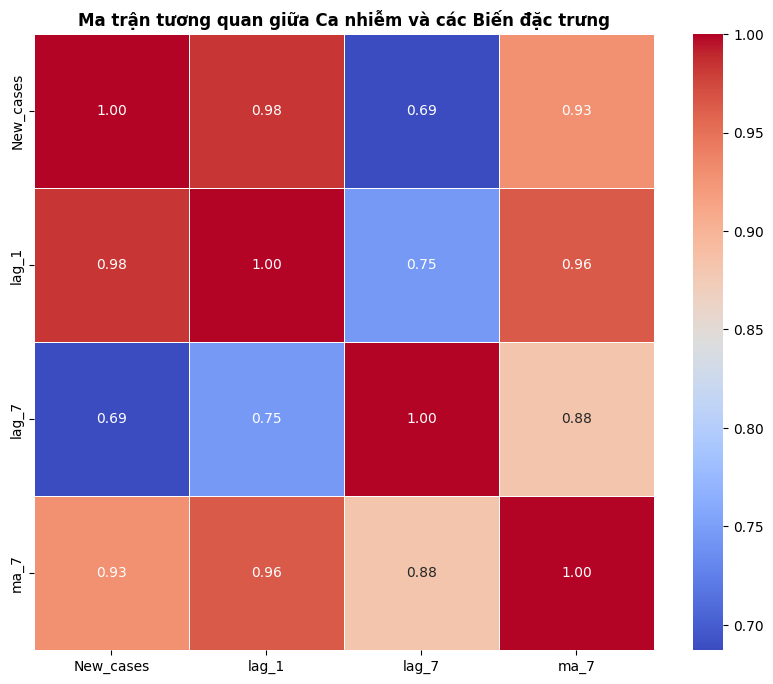

In [29]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Ma trận tương quan giữa Ca nhiễm và các Biến đặc trưng', fontweight='bold')
plt.savefig("../results/charts/correlation_matrix_new_cases_features.png")
plt.show()
plt.close()

**Nhận xét:**
* Biểu đồ nhiệt (Heatmap) chỉ ra mối tương quan tuyến tính gần như tuyệt đối (>0.92)
giữa biến mục tiêu (new_cases) và các biến phái sinh như MA_7 hay Lag_1.

* Điều này hứa hẹn các mô hình như Random Forest hay XGBoost sẽ đạt độ chính xác cao
khi học được các mẫu hình (patterns) từ các biến này.


## Một số biểu đồ khác

In [ ]:
df["Date_reported"] = pd.to_datetime(df["Date_reported"])

### BIỂU ĐỒ 10: PEAK/WAVE DETECTION

In [ ]:
for c in df["Country"].unique():
    sub = df[df["Country"] == c]
    peaks, _ = find_peaks(sub["New_cases"], distance=14)

    plt.figure(figsize=(14,6))
    plt.plot(sub["Date_reported"], sub["New_cases"])
    plt.scatter(sub.iloc[peaks]["Date_reported"], sub.iloc[peaks]["New_cases"], color="black", label="Peaks")

    plt.title(f"Wave (Peak) Detection – {c}")
    plt.xlabel("Date")
    plt.ylabel("New Cases")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../results/charts/wave_detection_covid19_{c.replace(' ', '_').lower()}.png")
    plt.show()
    plt.close()

### BIỂU ĐỒ 11: CCF
Tương quan chéo giữa các quốc gia.

In [11]:
df.columns

Index(['Date_reported', 'Country_code', 'Country', 'WHO_region', 'New_cases',
       'New_deaths', 'Cumulative_cases', 'Cumulative_deaths', 'Growth_Rate',
       'Cases_lag_7', 'Cases_lag_14', 'Cases_roll_7', 'Deaths_roll_7',
       'Cases_diff'],
      dtype='object')

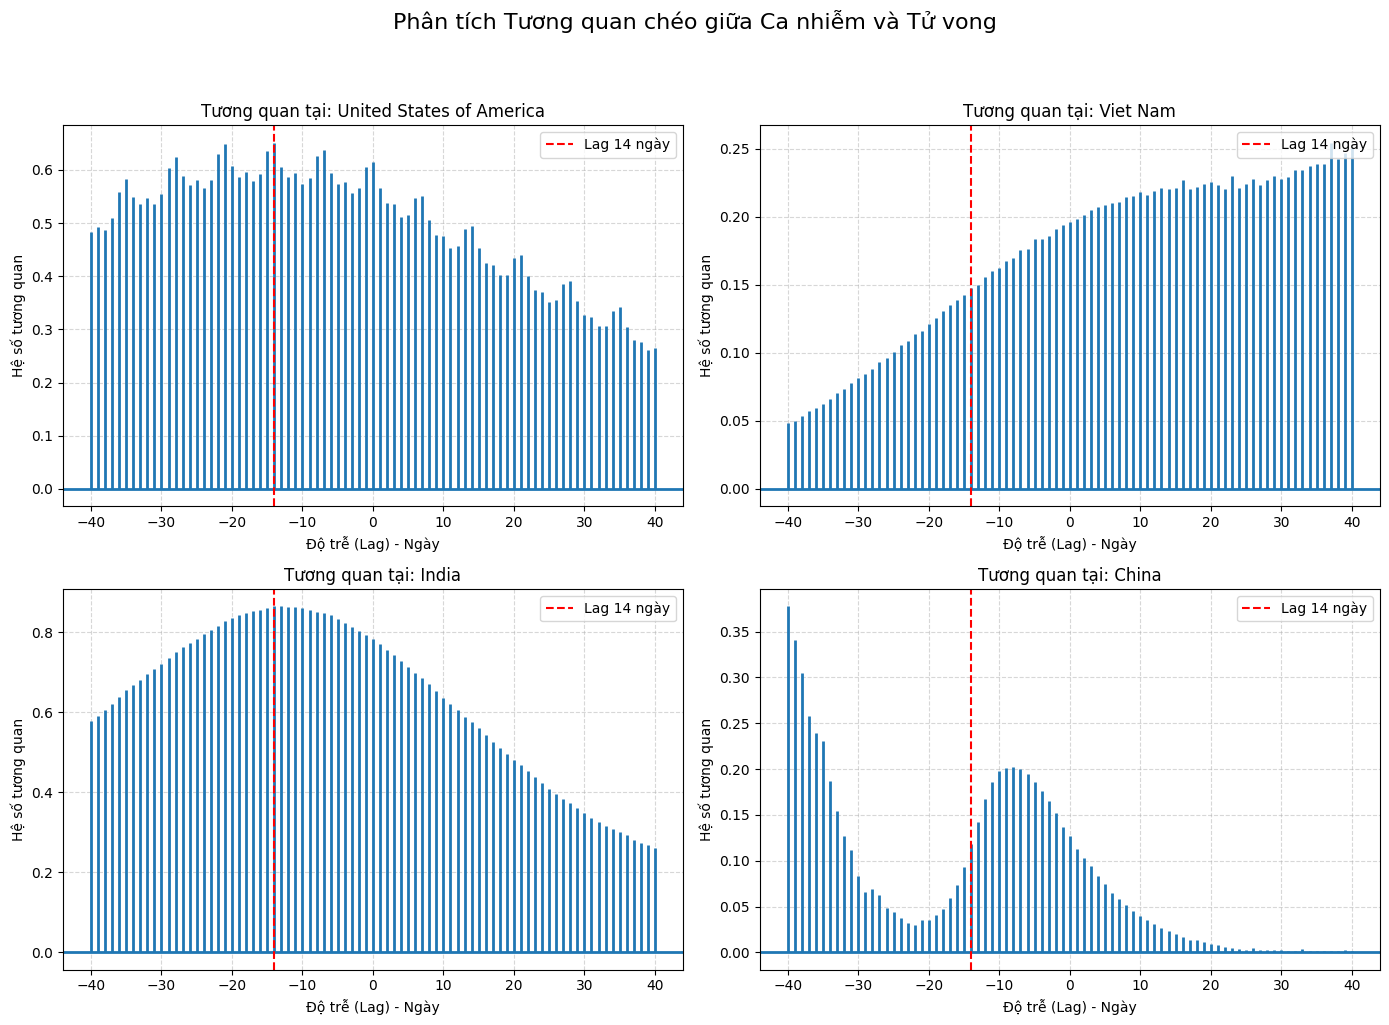

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Danh sách các quốc gia cần phân tích
countries = ['United States of America', 'Viet Nam', 'India', 'China']

# Tạo một lưới 2x2 cho 4 biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) # Kích thước hình lớn hơn để dễ nhìn
fig.suptitle('Phân tích Tương quan chéo giữa Ca nhiễm và Tử vong', fontsize=16, y=1.02)

# Vòng lặp để vẽ từng biểu đồ con
for i, country_name in enumerate(countries):
    # Xác định vị trí của subplot (hàng, cột)
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # --- CHUẨN BỊ DỮ LIỆU (Giả định df đã được load) ---
    # Thay thế phần này bằng code thực tế của bạn để lấy và chuẩn hóa dữ liệu
    # Ví dụ:
    df_country = df[df['Country'] == country_name].copy()
    cases = df_country['New_cases'].fillna(0)
    deaths = df_country['New_deaths'].fillna(0)
    cases_norm = (cases - cases.mean()) / cases.std()
    deaths_norm = (deaths - deaths.mean()) / deaths.std()

    # Vẽ biểu đồ Tương quan chéo (Cross Correlation) trên subplot hiện tại (ax)
    ax.xcorr(cases_norm, deaths_norm, maxlags=40, usevlines=True, normed=True, lw=2)
    ax.set_title(f'Tương quan tại: {country_name}', fontsize=12)
    
    # Thiết lập nhãn trục
    ax.set_xlabel('Độ trễ (Lag) - Ngày')
    ax.set_ylabel('Hệ số tương quan')
    
    # Thêm đường tham chiếu và lưới
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.axvline(x=-14, color='red', linestyle='--', label='Lag 14 ngày')
    ax.legend(loc='upper right')

# Điều chỉnh khoảng cách giữa các subplot cho gọn gàng hơn
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Điều chỉnh cho tiêu đề chính (suptitle) không bị che
# Lưu hình ảnh và hiển thị
plt.savefig(f"../results/charts/cross_correlation_cases_deaths_combo.png")
plt.show()
plt.close()

**1.Ấn Độ (India): Mô hình "Chuẩn mực"**

* Hình dáng: Biểu đồ của Ấn Độ có dạng hình chuông (Bell-shaped) hoàn hảo và rất mượt mà.

* Đỉnh tương quan: Đỉnh của đường cong nằm chính xác tại khu vực Lag -10 đến -15, trùng khớp gần như tuyệt đối với đường kẻ đỏ (Lag -14). Hệ số tương quan tại đỉnh đạt mức rất cao (> 0.8).

* Nhận xét: Đây là minh chứng rõ ràng nhất cho mối quan hệ nhân quả: Làn sóng ca nhiễm tại Ấn Độ dẫn dắt làn sóng tử vong với một độ trễ cực kỳ ổn định khoảng 2 tuần. Dữ liệu này rất lý tưởng cho các mô hình hồi quy tuyến tính.

**2.Hoa Kỳ (USA): Tương quan mạnh và độ trễ rộng**

* Hình dáng: Biểu đồ không nhọn như Ấn Độ mà có dạng "vùng đỉnh" rộng (broad peak).

* Đỉnh tương quan: Hệ số tương quan duy trì ở mức cao (> 0.6) trong một khoảng rộng từ Lag -5 đến Lag -25. Đường đỏ Lag -14 nằm ngay trung tâm của vùng tương quan cao nhất này.

* Nhận xét: Mối liên hệ giữa nhiễm và tử vong tại Mỹ rất chặt chẽ. Tuy nhiên, vùng đỉnh rộng phản ánh sự đa dạng của dữ liệu: do Mỹ có diện tích lớn, nhiều bang với hệ thống y tế khác nhau, nên thời gian từ lúc nhiễm đến lúc tử vong có độ biến thiên lớn (có người mất sớm, có người cầm cự lâu), nhưng trung bình vẫn xoay quanh mốc 14-21 ngày.

**3.Trung Quốc (China): Sự bất thường của chính sách**

* Hình dáng: Biểu đồ có dạng đa đỉnh (multi-modal) và rất nhiễu, khác biệt hoàn toàn so với các nước khác.

* Đỉnh tương quan: Xuất hiện một đỉnh cực đại kỳ lạ ở Lag -40 và một đỉnh phụ quanh Lag -8. Tại mốc Lag -14 (đường đỏ), tương quan khá thấp.

* Nhận xét: Sự bất thường này phản ánh tác động của chính sách "Zero-COVID" và việc dỡ bỏ phong tỏa đột ngột vào cuối năm 2022. Tại Trung Quốc, số liệu tử vong thường được ghi nhận tập trung hoặc có độ trễ báo cáo rất lớn so với thời điểm nhiễm bệnh thực tế, khiến cho mô hình tương quan chéo bị méo mó. Việc dự báo tử vong tại Trung Quốc dựa trên ca nhiễm sẽ khó khăn hơn các nước khác.

**4.Việt Nam: Tương quan dương nhưng phân tán**

* Hình dáng: Các thanh tương quan đều dương nhưng không tạo thành đỉnh nhọn tại Lag -14 mà có xu hướng tăng dần về phía Lag 0 hoặc các Lag dương.

* Đỉnh tương quan: Tại Lag -14 (đường đỏ), hệ số tương quan ở mức trung bình thấp (~0.15).

* Nhận xét: Điều này phản ánh hiện tượng "Tách dòng biên độ" đã phân tích ở phần trước. Trong giai đoạn bùng phát mạnh nhất (2022), số ca nhiễm tại Việt Nam cực cao nhưng tử vong lại thấp nhờ vắc-xin, làm suy yếu mối tương quan thống kê trực tiếp. Tuy nhiên, việc các hệ số tại Lag âm đều dương xác nhận rằng ca nhiễm tăng vẫn là tín hiệu báo trước cho tử vong, dù mức độ tác động đã giảm đi.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

def compute_ccf(x, y, max_lag=30):
    """
    Tính cross-correlation giữa hai chuỗi x và y với độ trễ tối đa ±max_lag.
    """
    x = (x - x.mean()) / x.std()
    y = (y - y.mean()) / y.std()

    full_corr = np.correlate(x, y, mode='full')
    mid = len(full_corr)//2

    # Lấy phần ±max_lag
    lags = np.arange(-max_lag, max_lag+1)
    ccf_values = full_corr[mid-max_lag:mid+max_lag+1]

    return lags, ccf_values / ccf_values.max()


In [ ]:
countries = df["Country"].unique()
def plot_ccf_between_countries(df, countries, max_lag=30):
    plt.figure(figsize=(14, 10))
    plot_idx = 1

    # Lấy danh sách cặp quốc gia
    pairs = [(a, b) for i, a in enumerate(countries) for b in countries[i+1:]]

    total = len(pairs)
    rows = int(np.ceil(total / 2))

    for (c1, c2) in pairs:
        df1 = df[df["Country"] == c1]["New_cases"].reset_index(drop=True)
        df2 = df[df["Country"] == c2]["New_cases"].reset_index(drop=True)

        # Bảo đảm độ dài bằng nhau
        min_len = min(len(df1), len(df2))
        df1 = df1[:min_len]
        df2 = df2[:min_len]

        lags, vals = compute_ccf(df1, df2, max_lag=max_lag)

        plt.subplot(rows, 2, plot_idx)
        plt.stem(lags, vals)
        plt.title(f"CCF: {c1} vs {c2} (±{max_lag} days)")
        plt.xlabel("Lag (days)")
        plt.ylabel("Correlation")
        plt.grid(alpha=0.3)

        plot_idx += 1

    plt.tight_layout()
    plt.savefig("../results/charts/ccf_between_countries.png")
    plt.show()
    plt.close()
   


In [ ]:
plot_ccf_between_countries(df, countries, max_lag=30)

### Biểu đồ tương quan
Biểu đồ này giúp trả lời câu hỏi: "Các chỉ số có liên quan gì đến nhau không?" (Ví dụ: Số ca mắc mới có tương đồng với số ca tử vong hay mật độ dân số không?).

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

numeric_cols = ['New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths', 'Population']
corr_matrix = df[numeric_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 3. Vẽ biểu đồ
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True,          # Hiển thị con số cụ thể
            fmt=".2f",           # Làm tròn 2 chữ số thập phân
            cmap='coolwarm',     # Màu từ Xanh (nghịch biến) sang Đỏ (đồng biến)
            vmin=-1, vmax=1,     # Cố định thang đo từ -1 đến 1
            linewidths=0.5,      # Đường viền trắng giữa các ô
            square=True)         # Ép các ô thành hình vuông cho đẹp

plt.title('Correlation Matrix of COVID-19 Metrics', fontsize=16)
plt.tight_layout()
plt.show()
plt.close()

### Biểu đồ bong bóng

In [ ]:
import plotly.express as px

# 1. Lấy dữ liệu mới nhất của từng nước
df_bubble = df.groupby("Country").agg({
    "Cumulative_cases": "max",
    "Cumulative_deaths": "max",
    "Population": "max"  # Lấy dân số
}).reset_index()

# 2. Tính tỷ lệ tử vong (Case Fatality Rate - CFR) để hiển thị khi hover
df_bubble["CFR (%)"] = (df_bubble["Cumulative_deaths"] / df_bubble["Cumulative_cases"]) * 100
# 3. Vẽ biểu đồ bong bóng
fig = px.scatter(df_bubble, 
                 x="Cumulative_cases", 
                 y="Cumulative_deaths",
                 size="Population",          # Kích thước bóng theo dân số
                 color="Country",            # Mỗi nước 1 màu
                 hover_name="Country",
                 hover_data=["CFR (%)"],     # Hiện thêm tỷ lệ tử vong
                 log_x=True, log_y=True,     # Dùng thang Log để nhìn rõ cả nước lớn và nhỏ
                 size_max=60,                # Giới hạn kích thước bóng to nhất
                 title="Relationship: Cases vs. Deaths (Size = Population)")

fig.show()

### Biểu đồ Treemap (Biểu đồ cây) - Tỷ trọng toàn cầu

In [ ]:
df_tree = df_bubble.sort_values("Cumulative_cases", ascending=False)
fig = px.treemap(df_tree, 
                 path=['Country'],              # Phân cấp (nếu có Châu lục thì để [Continent, Country])
                 values='Cumulative_cases',     # Diện tích ô
                 color='Cumulative_deaths',     # Màu sắc ô
                 color_continuous_scale='RdBu_r', # Đỏ đậm là chết nhiều
                 title="Top 4 Countries by Cases (Area) & Deaths (Color)")

fig.show()

### Biểu đồ Lollipop (Biểu đồ kẹo mút) - Xếp hạng chỉ số bình quân

In [ ]:
import matplotlib.pyplot as plt

# 1. Tính toán chỉ số Cases per 1M (nếu chưa có)
df_latest = df.groupby("Country").max().reset_index()
df_latest["Cases_per_1M"] = (df_latest["Cumulative_cases"] / df_latest["Population"]) * 1000000

# 2. Lấy Top 15 nước có tỷ lệ nhiễm cao nhất
df_lolli = df_latest.sort_values("Cases_per_1M", ascending=True).tail(15)

# 3. Vẽ biểu đồ
plt.figure(figsize=(10, 8))

# Vẽ đường que (stem)
plt.hlines(y=df_lolli["Country"], xmin=0, xmax=df_lolli["Cases_per_1M"], color='skyblue')

# Vẽ đầu kẹo (point)
plt.plot(df_lolli["Cases_per_1M"], df_lolli["Country"], "o", markersize=10, color='blue')

plt.title("Top 15 Countries: Cases per 1 Million People", fontsize=14)
plt.xlabel("Cases per 1M")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## PHÂN CỤM - K-MEANS CLUSTERING

Sau khi đã phân tích sâu 4 nước kia trên, "Liệu các đặc điểm này có đúng với toàn thế giới không? Hay chúng ta có thể nhóm các quốc gia có đặc điểm giống nhau lại?"

In [ ]:
import pandas as pd
df = pd.read_csv("../data/processed/01_clean_daily_timeseries.csv.gz", compression='gzip')
df.columns

In [ ]:
df_country = pd.read_csv("../data/processed/02_country_population_summary.csv.gz", compression='gzip')
df["Population"] = df["Country"].map(df_country.set_index("Country")["Population"])
df.columns

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chuẩn bị dữ liệu cho Clustering (Lấy số liệu mới nhất của mỗi nước)
df_cluster = df.groupby('Country').agg({
    'Cumulative_cases': 'max',
    'Cumulative_deaths': 'max',
    'Population': 'max'
}).reset_index()

# Tính thêm CFR để phân cụm cho chính xác hơn
df_cluster['CFR'] = df_cluster['Cumulative_deaths'] / df_cluster['Cumulative_cases']
df_cluster = df_cluster.fillna(0)

# Lọc bỏ các nước quá nhỏ hoặc lỗi data để biểu đồ đẹp hơn
df_cluster = df_cluster[df_cluster['Cumulative_cases'] > 1000]

# 2. Chuẩn hóa dữ liệu (Quan trọng cho K-Means)
features = ['Cumulative_cases', 'Cumulative_deaths', 'CFR']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])

# 3. Vẽ Elbow Method
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('Inertia (Độ lỗi)')
plt.title('Phương pháp Elbow để chọn K tối ưu')
plt.savefig("../results/charts/elbow_method_kmeans.png")
plt.show()          
plt.close()

Dựa trên biểu đồ Elbow, độ lỗi (Inertia) bắt đầu giảm chậm lại rõ rệt tại K=3. Do đó, nghiên cứu quyết định chia các quốc gia trên thế giới thành 3 cụm (Clusters) chính.

In [ ]:
# 4. Chạy K-Means với K=3 
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

# Vẽ Scatter Plot kết quả
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='Cumulative_cases', y='Cumulative_deaths', 
                hue='Cluster', palette='viridis', s=100)

# Đánh dấu 4 nước chúng ta quan tâm
target_countries = ['United States of America', 'India', 'China', 'Viet Nam']
for i, row in df_cluster.iterrows():
    if row['Country'] in target_countries:
        plt.text(row['Cumulative_cases'], row['Cumulative_deaths'], row['Country'], 
                 fontsize=11, color='red', weight='bold')

plt.xscale('log') 
plt.yscale('log')
plt.title('Phân cụm các quốc gia (K-Means Clustering)')
plt.xlabel('Tổng ca nhiễm (Log Scale)')
plt.ylabel('Tổng tử vong (Log Scale)')
plt.savefig("../results/charts/kmeans_clustering_countries.png")
plt.show()
plt.close()
# In ra xem các nước thuộc cụm nào để viết báo cáo cho đúng
print(df_cluster[df_cluster['Country'].isin(target_countries)][['Country', 'Cluster']])   

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import numpy as np

# 1. Tính Silhouette Score trung bình
sil_score = silhouette_score(X_scaled, df_cluster['Cluster'])
print(f"Silhouette Score trung bình (K=3): {sil_score:.3f}")

# (Tùy chọn) 2. Vẽ biểu đồ Silhouette để báo cáo thêm phần chuyên nghiệp


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# --- CẤU HÌNH ---
X_plot = X_scaled  # Dữ liệu đầu vào
labels = df_cluster['Cluster']  # Nhãn dự báo từ K-Means
n_clusters = 3  # Số cụm

# 1. Thiết lập khung hình
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

# Giới hạn trục X từ -0.1 đến 1 (Silhouette score nằm trong khoảng này)
ax1.set_xlim([-0.1, 1])
# Giới hạn trục Y (tổng số mẫu + khoảng trống giữa các cụm)
ax1.set_ylim([0, len(X_plot) + (n_clusters + 1) * 10])

# 2. Tính giá trị Silhouette cho từng điểm dữ liệu
sample_silhouette_values = silhouette_samples(X_plot, labels)
silhouette_avg = silhouette_score(X_plot, labels)

y_lower = 10
for i in range(n_clusters):
    # Lấy giá trị silhouette của các điểm thuộc cụm i và sắp xếp
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Chọn màu
    color = cm.nipy_spectral(float(i) / n_clusters)
    
    # Vẽ hình dáng (Silhouette)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Đánh số cụm ở giữa
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Tính toán y_lower cho cụm tiếp theo
    y_lower = y_upper + 10 

# 3. Vẽ đường trung bình (Average Line)
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_title("Biểu đồ phân tích Silhouette cho K-Means (K=3)")
ax1.set_xlabel("Hệ số Silhouette (Silhouette Coefficient)")
ax1.set_ylabel("Nhãn Cụm (Cluster Label)")

# 4. Chú thích đường trung bình
ax1.text(silhouette_avg + 0.02, y_lower * 0.9, f'Average Score: {silhouette_avg:.2f}', 
         color='red', weight='bold')
plt.savefig("../results/charts/silhouette_analysis_kmeans.png")
plt.show()
plt.close()